<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/04-oec/licitacap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações visuais para os gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [7]:
# Definição dos arquivos de entrada
arquivos_alvo = sorted(
    os.path.join('dados', f)
    for f in os.listdir('dados')
    if f.lower().endswith('.csv')
)

lista_df = []

# Processamento de leitura
for arquivo in arquivos_alvo:
    if os.path.exists(arquivo):
        print(f"Processando: {arquivo}")
        # Lendo com os parâmetros corretos de separador e encoding
        try:
            temp_df = pd.read_csv(arquivo, sep=';', encoding='cp1252', low_memory=False)
        except UnicodeDecodeError:
            temp_df = pd.read_csv(arquivo, sep=';', encoding='cp1250', low_memory=False)
        lista_df.append(temp_df)
    else:
        print(f"Erro: Arquivo {arquivo} não encontrado.")

# União e salvamento
if lista_df:
    df = pd.concat(lista_df, ignore_index=True)
    arquivo_saida = "Licitacoes_Consolidado.csv"
    df.to_csv(arquivo_saida, sep=';', encoding='utf-8', index=False)

    print("-" * 30)
    print(f"Sucesso! Total de registros: {len(df)}")
else:
    print("Falha: Nenhum dado foi carregado.")


Processando: dados/201901_Licitação.csv
Processando: dados/201902_Licitação.csv
Processando: dados/201903_Licitação.csv
Processando: dados/201904_Licitação.csv
Processando: dados/201905_Licitação.csv
Processando: dados/201906_Licitação.csv
Processando: dados/201907_Licitação.csv
Processando: dados/201908_Licitação.csv
Processando: dados/201909_Licitação.csv
Processando: dados/201910_Licitação.csv
Processando: dados/201911_Licitação.csv
Processando: dados/201912_Licitação.csv
Processando: dados/202001_Licitação.csv
Processando: dados/202002_Licitação.csv
Processando: dados/202003_Licitação.csv
Processando: dados/202004_Licitação.csv
Processando: dados/202005_Licitação.csv
Processando: dados/202006_Licitação.csv
Processando: dados/202007_Licitação.csv
Processando: dados/202008_Licitação.csv
Processando: dados/202009_Licitação.csv
Processando: dados/202010_Licitação.csv
Processando: dados/202011_Licitação.csv
Processando: dados/202012_Licitação.csv
Processando: dados/202101_Licitação.csv


In [8]:
df.describe()

,Número Licitação,Código UG,Código Modalidade Compra,Código Órgão Superior,Código Órgão
count,6.369610e+05,636961.000000,636961.000000,636961.000000,636961.000000
mean,1.739209e+07,253736.049472,1417.586906,39279.551888,38720.779473
std,1.004007e+08,211246.985503,3480.399828,13298.150709,13833.696071
min,1.201300e+04,30100.000000,1.000000,3000.000000,3000.000000
25%,1.220190e+05,154047.000000,6.000000,26000.000000,26263.000000
50%,3.820210e+05,160199.000000,6.000000,36000.000000,36000.000000
75%,1.142020e+06,240003.000000,7.000000,52000.000000,52121.000000
max,9.999320e+08,930182.000000,9999.000000,96111.000000,96111.000000


In [9]:
# 1. Tratamento da coluna de Valor

df = df.rename(columns={"Valor Licitação": "Valor_Licitacao"})
df = df.rename(columns={"Data Resultado Compra": "Data_Resultado_Compra"})
df = df.rename(columns={"Data Abertura": "Data_Abertura"})
df = df.rename(columns={"Modalidade Compra": "Modalidade_Compra"})

# Removemos a vírgula e convertemos para numérico
df['Valor_Licitacao'] = (
    df['Valor_Licitacao']
    .astype(str)
    .str.replace(',', '.')
)
df['Valor_Licitacao'] = pd.to_numeric(df['Valor_Licitacao'], errors='coerce')

# 2. Tratamento das colunas de Data
colunas_data = ['Data_Resultado_Compra', 'Data_Abertura']
for col in colunas_data:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')

# 3. Cálculo da Duração (Feature Engineering)
df['Duracao_dias'] = (df['Data_Resultado_Compra'] - df['Data_Abertura']).dt.days

# Verificação final dos tipos
print("Novos tipos de dados nas colunas principais:")
print(df[['Valor_Licitacao', 'Data_Resultado_Compra', 'Data_Abertura', 'Duracao_dias']].dtypes)
print(f"\nValores nulos encontrados na Duração: {df['Duracao_dias'].isna().sum()}")


Novos tipos de dados nas colunas principais:
Valor_Licitacao                 float64
Data_Resultado_Compra    datetime64[ns]
Data_Abertura            datetime64[ns]
Duracao_dias                    float64
dtype: object

Valores nulos encontrados na Duração: 440094


In [10]:
# 1. Criando o resumo novamente (garantindo que os dados estão limpos)
resumo_estatistico = df.groupby('Modalidade_Compra').agg({
    'Valor_Licitacao': ['count', 'mean', 'sum'],
    'Duracao_dias': 'mean'
}).reset_index()

# 2. Renomeando
resumo_estatistico.columns = [
    'Modalidade',
    'Qtd_Processos',
    'Valor_Medio',
    'Valor_Total',
    'Media_Dias_Processo'
]

# 3. Tratamento de NaNs (substitui por 0 onde não foi possível calcular a duração)
resumo_estatistico['Media_Dias_Processo'] = resumo_estatistico['Media_Dias_Processo'].fillna(0)

# 4. Ordenação
resumo_estatistico = resumo_estatistico.sort_values(by='Qtd_Processos', ascending=False)

# 5. Exibição Formatada (Sem notação científica e com separadores)
formatacao = {
    'Valor_Medio': 'R$ {:,.2f}',
    'Valor_Total': 'R$ {:,.2f}',
    'Media_Dias_Processo': '{:.1f} dias',
    'Qtd_Processos': '{:,}'
}

# Exibindo a tabela estilizada
resumo_estatistico.style.format(formatacao).hide(axis='index')


Modalidade,Qtd_Processos,Valor_Medio,Valor_Total,Media_Dias_Processo
Dispensa de Licitação,"391,834","R$ 252,873.94","R$ 99,084,609,063.11",21.9 dias
Inexigibilidade de Licitação,"90,732","R$ 974,845.05","R$ 88,449,640,765.97",0.0 dias
Pregão - Registro de Preço,"89,948","R$ 40,573,979.11","R$ 3,649,548,272,808.00",38.7 dias
Pregão,"60,248","R$ 1,562,092.98","R$ 94,112,977,781.11",24.7 dias
Tomada de Preços,"2,848","R$ 588,348.26","R$ 1,675,615,853.19",0.0 dias
Concorrência,955,"R$ 27,095,762.60","R$ 25,876,453,278.30",0.0 dias
Convite,294,"R$ 128,414.11","R$ 37,753,747.09",0.0 dias
Concurso,67,"R$ 65,226.29","R$ 4,370,161.45",0.0 dias
Concorrência - Registro de Preço,26,"R$ 68,075.86","R$ 1,769,972.38",0.0 dias
Concorrência Internacional,9,"R$ 2,493,272.19","R$ 22,439,449.70",0.0 dias


/tmp/ipykernel_6707/2776524386.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


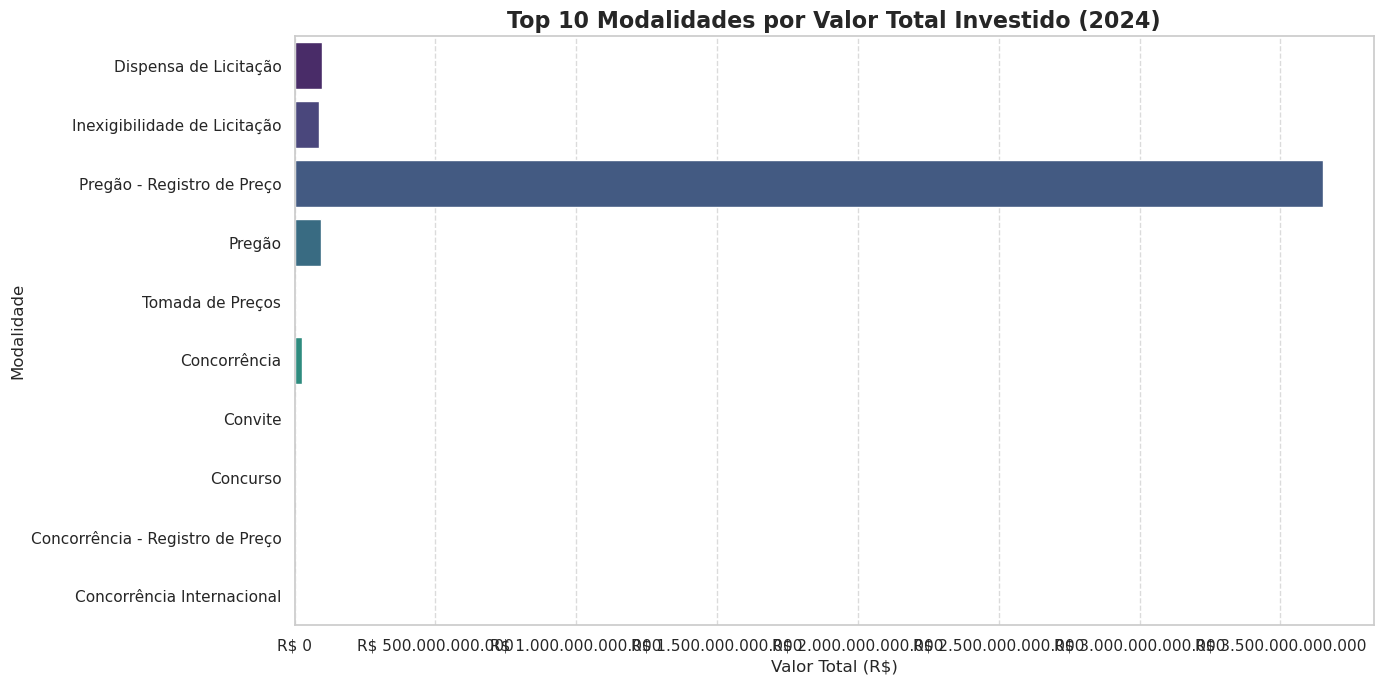

In [11]:
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    data=resumo_estatistico.head(10),
    x='Valor_Total',
    y='Modalidade',
    palette='viridis'
)

# Formatação de Moeda (R$) no eixo X
formatter = mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'.replace(',', 'X').replace('.', ',').replace('X', '.'))
ax.xaxis.set_major_formatter(formatter)

plt.title('Top 10 Modalidades por Valor Total Investido (2024)', fontsize=16, fontweight='bold')
plt.xlabel('Valor Total (R$)', fontsize=12)
plt.ylabel('Modalidade', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


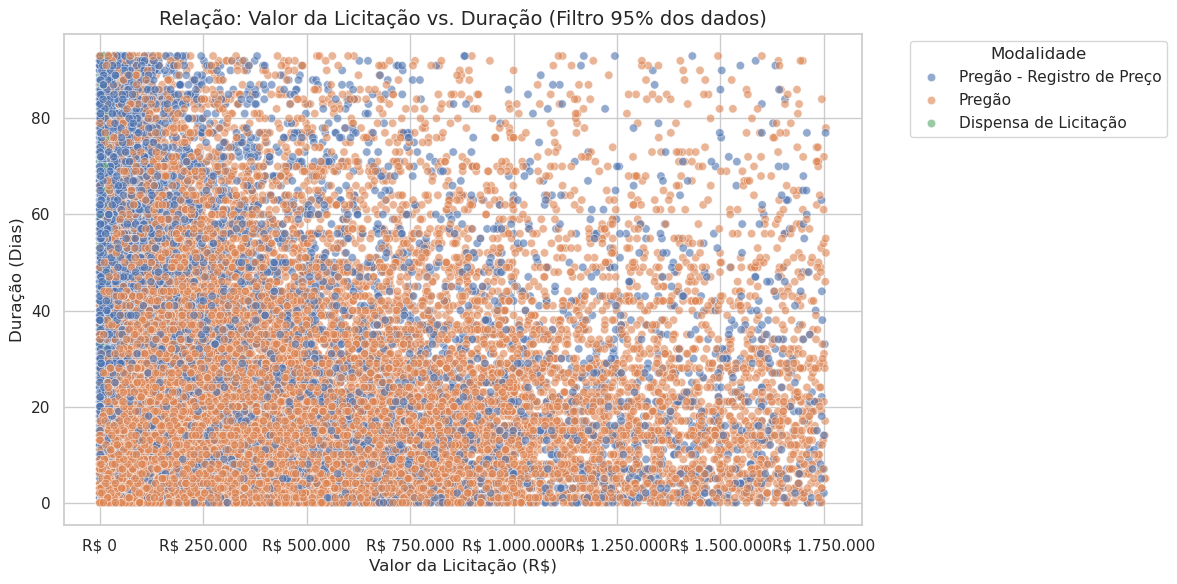

In [12]:
df_plot = df[(df['Valor_Licitacao'] > 0) & (df['Duracao_dias'] >= 0)].copy()

limite_valor = df_plot['Valor_Licitacao'].quantile(0.95)
limite_dias = df_plot['Duracao_dias'].quantile(0.95)

df_filtrado = df_plot[(df_plot['Valor_Licitacao'] <= limite_valor) & (df_plot['Duracao_dias'] <= limite_dias)]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_filtrado,
    x='Valor_Licitacao',
    y='Duracao_dias',
    hue='Modalidade_Compra',
    alpha=0.6
)

plt.title('Relação: Valor da Licitação vs. Duração (Filtro 95% dos dados)', fontsize=14)
plt.xlabel('Valor da Licitação (R$)', fontsize=12)
plt.ylabel('Duração (Dias)', fontsize=12)

# Formatação do eixo X como moeda
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)

plt.legend(title='Modalidade', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


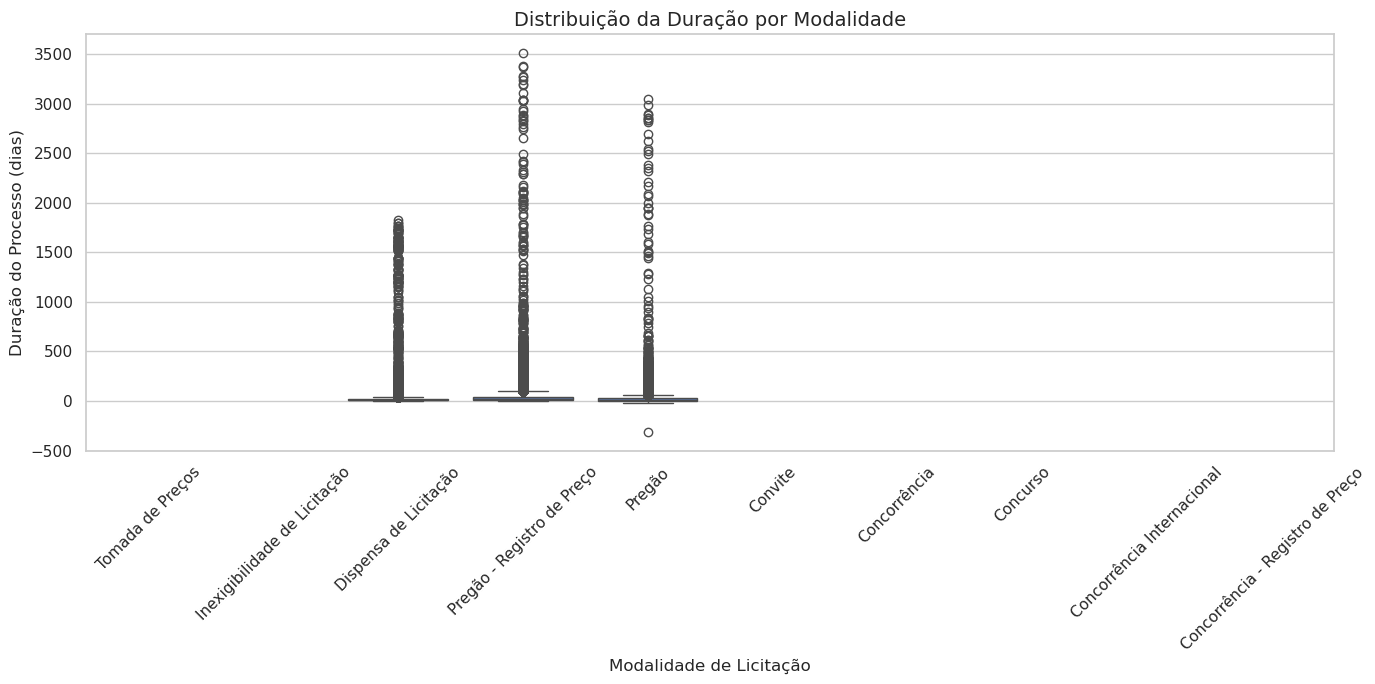

In [13]:
#  Distribuição da duração por modalidade (Boxplot)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

sns.boxplot(
    data=df,
    x='Modalidade_Compra',
    y='Duracao_dias'
)

plt.xticks(rotation=45)
plt.title('Distribuição da Duração por Modalidade', fontsize=14)
plt.xlabel('Modalidade de Licitação', fontsize=12)
plt.ylabel('Duração do Processo (dias)', fontsize=12)

plt.tight_layout()
plt.show()


In [27]:
# Detecção de casos anômalos

# Calculando o limite superior do top 10% mais demorado
p90 = df['Duracao_dias'].quantile(0.90)

print(f"Percentil 90 da duração: {p90:.2f} dias")

# Criando coluna indicadora de possível reprocesso
df['Possivel_Reprocesso'] = df['Duracao_dias'] > p90

# Estatísticas por modalidade e grupo
resultado_analise = df.groupby(['Modalidade_Compra', 'Possivel_Reprocesso'])['Duracao_dias'] \
                      .agg(['count', 'mean', 'median']).reset_index()

print("\nResumo da análise de reprocessos:")
print(resultado_analise)


Percentil 90 da duração: 116.00 dias

Resumo da análise de reprocessos:
              Modalidade_Compra  Possivel_Reprocesso  count         mean  \
0                  Concorrência                False      0          NaN   
1                       Convite                False      0          NaN   
2         Dispensa de Licitação                False     18    51.777778   
3         Dispensa de Licitação                 True    167  1223.209581   
4  Inexigibilidade de Licitação                False      0          NaN   
5                        Pregão                False   1940    27.294330   
6                        Pregão                 True     76   168.881579   
7    Pregão - Registro de Preço                False   3583    35.460787   
8    Pregão - Registro de Preço                 True    368   178.418478   
9              Tomada de Preços                False      0          NaN   

   median  
0     NaN  
1     NaN  
2    49.5  
3  1273.0  
4     NaN  
5    20.0  
6   148

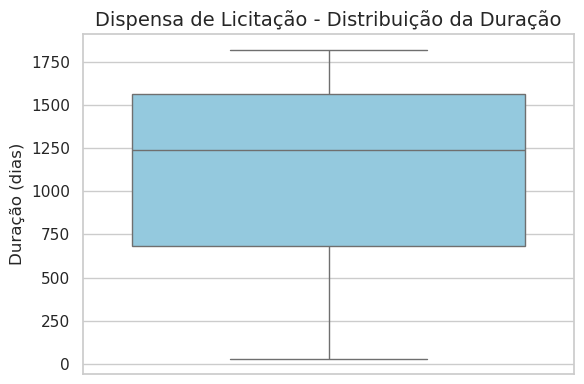

Gráfico 1 salvo como: boxplot_dispensa.png


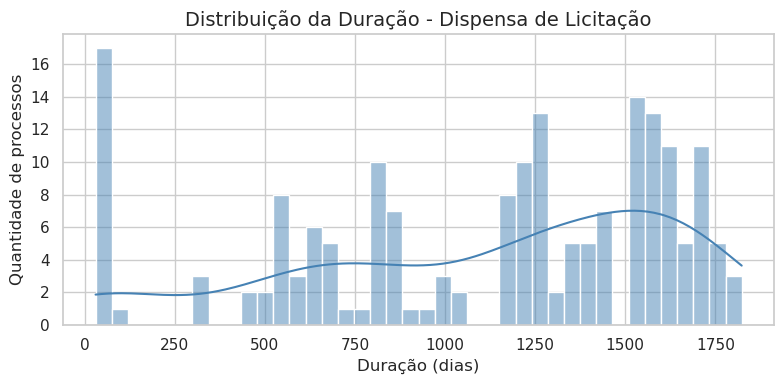

Gráfico 2 salvo como: histograma_dispensa.png


In [28]:
# Filtrar apenas dispensa
df_dispensa = df[df['Modalidade_Compra'] == 'Dispensa de Licitação']

# 1) Boxplot da Dispensa
plt.figure(figsize=(6, 4))
sns.boxplot(y=df_dispensa['Duracao_dias'], color='skyblue')
plt.title('Dispensa de Licitação - Distribuição da Duração', fontsize=14)
plt.ylabel('Duração (dias)')
plt.tight_layout()
plt.savefig('boxplot_dispensa.png', dpi=300)
plt.show()

print("Gráfico 1 salvo como: boxplot_dispensa.png")


# 2) Histograma da duração da Dispensa
plt.figure(figsize=(8, 4))
sns.histplot(df_dispensa['Duracao_dias'], bins=40, kde=True, color='steelblue')
plt.title('Distribuição da Duração - Dispensa de Licitação', fontsize=14)
plt.xlabel('Duração (dias)')
plt.ylabel('Quantidade de processos')
plt.tight_layout()
plt.savefig('histograma_dispensa.png', dpi=300)
plt.show()

print("Gráfico 2 salvo como: histograma_dispensa.png")


In [ ]:
# --- Analises: celeridade por modalidade, periodo normativo e UF ---
# Padroniza e cria variaveis de apoio
df_analise = df.copy()

# Base temporal: Data_Resultado_Compra
df_analise['Data_Resultado_Compra'] = pd.to_datetime(df_analise['Data_Resultado_Compra'], dayfirst=True, errors='coerce')

# Recorte temporal do estudo
inicio = pd.Timestamp('2019-01-01')
corte_transicao = pd.Timestamp('2021-04-01')
inicio_lei_14133 = pd.Timestamp('2024-01-01')
fim = pd.Timestamp('2024-04-30')

df_analise = df_analise[df_analise['Data_Resultado_Compra'].between(inicio, fim)]

# Classificacao de periodo normativo
def classificar_periodo(data):
    if pd.isna(data):
        return 'Sem_data'
    if data < corte_transicao:
        return 'Lei_8666'
    if data < inicio_lei_14133:
        return 'Transicao'
    return 'Lei_14133'

df_analise['Periodo_Normativo'] = df_analise['Data_Resultado_Compra'].apply(classificar_periodo)

# Grupo comparativo: Dispensa vs Outras modalidades
df_analise['Grupo_Modalidade'] = np.where(
    df_analise['Modalidade_Compra'] == 'Dispensa de Licitação',
    'Dispensa',
    'Outras'
)

# Remove duracoes negativas ou nulas para analise de celeridade
df_analise = df_analise[df_analise['Duracao_dias'].notna()]
df_analise = df_analise[df_analise['Duracao_dias'] >= 0]

df_analise[['UF', 'Modalidade_Compra', 'Periodo_Normativo']].value_counts().head()


In [ ]:
# 1) Estatisticas descritivas por modalidade e periodo
resumo_celeridade = df_analise.groupby(['Periodo_Normativo', 'Modalidade_Compra']).agg(
    Qtd_Processos=('Duracao_dias', 'count'),
    Media_Dias=('Duracao_dias', 'mean'),
    Mediana_Dias=('Duracao_dias', 'median'),
    P25=('Duracao_dias', lambda s: s.quantile(0.25)),
    P75=('Duracao_dias', lambda s: s.quantile(0.75))
).reset_index()

resumo_celeridade


In [ ]:
# Tabela por UF x periodo x modalidade
tabela_uf = df_analise.groupby(['UF', 'Periodo_Normativo', 'Modalidade_Compra']).agg(
    Qtd_Processos=('Duracao_dias', 'count'),
    Media_Dias=('Duracao_dias', 'mean'),
    Mediana_Dias=('Duracao_dias', 'median')
).reset_index()

tabela_uf = tabela_uf.sort_values(['UF', 'Periodo_Normativo', 'Qtd_Processos'], ascending=[True, True, False])

tabela_uf


In [ ]:
# 2) Proporcao de processos concluidos em ate 30 dias por modalidade
limite_dias = 30

taxa_ate_30 = (
    df_analise.assign(Ate_30=lambda x: x['Duracao_dias'] <= limite_dias)
    .groupby(['Periodo_Normativo', 'Modalidade_Compra'])['Ate_30']
    .mean()
    .reset_index(name='Proporcao_Ate_30')
)

taxa_ate_30


In [ ]:
# 3) Diferenca de medianas entre Dispensa de Licitacao e demais modalidades (por periodo)
dispensa_nome = 'Dispensa de Licitação'
medianas = df_analise.groupby(['Periodo_Normativo', 'Modalidade_Compra'])['Duracao_dias'].median().unstack()

if dispensa_nome in medianas.columns:
    medianas['Dif_Mediana_Dispensa_Menos_Outras'] = medianas[dispensa_nome] - medianas.drop(columns=[dispensa_nome]).median(axis=1)

medianas


In [ ]:
# 4) Intervalo de confianca por bootstrap para diferenca de medianas: Dispensa vs Competitiva
def bootstrap_diff_median(x, y, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    diffs = []
    x = np.asarray(x)
    y = np.asarray(y)
    for _ in range(n_boot):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.median(xb) - np.median(yb))
    return np.percentile(diffs, [2.5, 50, 97.5])

resultados_boot = []
for periodo, grupo in df_analise.groupby('Periodo_Normativo'):
    d = grupo[grupo['Modalidade_Compra'] == dispensa_nome]['Duracao_dias']
    c = grupo[grupo['Modalidade_Compra'] != dispensa_nome]['Duracao_dias']
    if len(d) >= 10 and len(c) >= 10:
        ci = bootstrap_diff_median(d, c)
        resultados_boot.append({
            'Periodo_Normativo': periodo,
            'IC_2_5': ci[0],
            'Mediana_Dif': ci[1],
            'IC_97_5': ci[2]
        })

pd.DataFrame(resultados_boot)


In [ ]:
# 5) Boxplot comparando modalidades por periodo
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_analise,
    x='Periodo_Normativo',
    y='Duracao_dias',
    hue='Modalidade_Compra'
)
plt.title('Duracao por Modalidade e Periodo Normativo')
plt.xlabel('Periodo Normativo')
plt.ylabel('Duracao (dias)')
plt.tight_layout()
plt.show()


In [ ]:
# Graficos por UF: Dispensa vs Outras modalidades por periodo
ufs = sorted(df_analise['UF'].dropna().unique())

for uf in ufs:
    dados_uf = df_analise[df_analise['UF'] == uf]
    if dados_uf.empty:
        continue

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=dados_uf,
        x='Periodo_Normativo',
        y='Duracao_dias',
        hue='Grupo_Modalidade'
    )
    plt.title(f'Duracao dos processos por periodo - UF {uf}')
    plt.xlabel('Periodo Normativo')
    plt.ylabel('Duracao (dias)')
    plt.tight_layout()
    plt.show()


In [ ]:
# 6) ECDF comparativa: Dispensa vs demais modalidades
plt.figure(figsize=(10, 6))
for label, filtro in [
    ('Dispensa de Licitação', df_analise['Modalidade_Compra'] == dispensa_nome),
    ('Outras modalidades', df_analise['Modalidade_Compra'] != dispensa_nome),
]:
    dados = np.sort(df_analise.loc[filtro, 'Duracao_dias'].values)
    if len(dados) == 0:
        continue
    y = np.arange(1, len(dados) + 1) / len(dados)
    plt.plot(dados, y, label=label)

plt.title('ECDF da Duracao: Dispensa vs Outras modalidades')
plt.xlabel('Duracao (dias)')
plt.ylabel('Proporcao cumulativa')
plt.legend()
plt.tight_layout()
plt.show()
